# CS 445 Final Project

## Real time tracking mask detection

Tony Chang, Ruiyang Dai, Tomoyoshi Kimura

## Imports

In [1]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Scale, Compose

import torch
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import transforms
from torch.autograd import Variable

from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import PIL

import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

import cv2

import numpy as np
from mtcnn import MTCNN

In [2]:
# GPU Support
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Image display function

In [3]:
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))  


## Data preprocessing

### Load data

In [4]:
data_dir = './Dataset'
dataset = ImageFolder(data_dir, transform=ToTensor())
print(len(dataset))
print(dataset.classes)

8982
['mask_weared_incorrect', 'with_mask', 'without_mask']


### Image size and normalization

In [5]:
image_size = (256,256)

dataset = ImageFolder(data_dir, transforms.Compose([
    # transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.Resize(image_size),
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

### Training validation partition

In [6]:
# 8 : 2 Train : Validation
val_pct = 0.2
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [7]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

## Image Classification

### Base class

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images= batch[0].to(device)
        labels = batch[1].to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)
        return {'loss': loss, 'acc': acc}

    def validation_step(self, batch):
        images = batch[0].to(device)
        labels = batch[1].to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

    def softmax(self, x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def predict(self, image):
        image = image.to(device)
        out = self(image).cpu().data.numpy()[0]
        softmax_out = self.softmax(out)
        res = np.argmax(softmax_out)
        return res, softmax_out

    def save_model(self, path):
        torch.save(self, path)
    
    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        

### Evaluation Functions

In [9]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    print("Start training %d epochs" % (epochs))
    for epoch in range(epochs):
        # Training Phase
        model.train().to(device)
        train_losses = []
        train_acc = []
        lrs = []
        for batch in tqdm(train_loader):
            res = model.training_step(batch)
            train_losses.append(res['loss'])
            train_acc.append(res['acc'])
            res['loss'].backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


### Data loader for prediction image

In [10]:
loader = Compose([Scale(image_size), ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = PIL.Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.to(device)  #assumes that you're using GPU

def prepare_image(image):
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.to(device)  #assumes that you're using GPU

c:\Users\ktomo\Documents\CS 445\venv\lib\site-packages\torchvision\transforms\transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


## Convolution Neural Network

## Transfer Learning with ResNet 34

### Model

In [11]:
from torchvision import models
models.resnet34(pretrained=True)

class MasksModel(ImageClassificationBase):

    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained) #downloading weights from this model when it was trained on ImageNet dataset
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)


### Training

In [49]:
model = MasksModel(len(dataset.classes), pretrained=True).to(device)
epoch = 20

history = fit_one_cycle(epoch, 0.001, model, train_dl, valid_dl, opt_func=torch.optim.Adam)

Start training 20 epochs


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00010, train_loss: 0.1104, val_loss: 0.0194, val_acc: 0.9948


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00028, train_loss: 0.0213, val_loss: 0.1325, val_acc: 0.9536


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00052, train_loss: 0.0566, val_loss: 0.5435, val_acc: 0.8443


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00076, train_loss: 0.0419, val_loss: 0.0788, val_acc: 0.9740


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00094, train_loss: 0.0682, val_loss: 0.0498, val_acc: 0.9859


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00100, train_loss: 0.0226, val_loss: 0.0665, val_acc: 0.9833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00099, train_loss: 0.0146, val_loss: 0.0461, val_acc: 0.9880


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00095, train_loss: 0.0209, val_loss: 0.0240, val_acc: 0.9937


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00089, train_loss: 0.0140, val_loss: 0.0247, val_acc: 0.9927


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00081, train_loss: 0.0207, val_loss: 0.0727, val_acc: 0.9786


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00072, train_loss: 0.0100, val_loss: 0.0235, val_acc: 0.9943


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00061, train_loss: 0.0009, val_loss: 0.0252, val_acc: 0.9948


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00050, train_loss: 0.0004, val_loss: 0.0273, val_acc: 0.9948


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00039, train_loss: 0.0007, val_loss: 0.0243, val_acc: 0.9953


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00028, train_loss: 0.0029, val_loss: 0.0310, val_acc: 0.9937


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15],last_lr: 0.00019, train_loss: 0.0012, val_loss: 0.0278, val_acc: 0.9948


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16],last_lr: 0.00011, train_loss: 0.0004, val_loss: 0.0255, val_acc: 0.9948


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17],last_lr: 0.00005, train_loss: 0.0002, val_loss: 0.0272, val_acc: 0.9958


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18],last_lr: 0.00001, train_loss: 0.0003, val_loss: 0.0244, val_acc: 0.9958


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19],last_lr: 0.00000, train_loss: 0.0002, val_loss: 0.0251, val_acc: 0.9953


### Plots

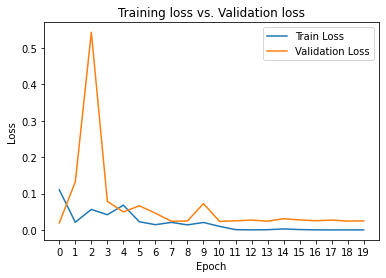

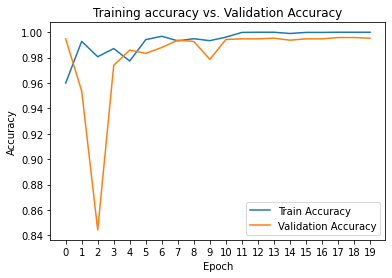

In [60]:
train_acc = [history[i]['train_acc'] for i in range(0, len(history))]
validation_acc = [history[i]['val_acc'] for i in range(0, len(history))]
train_loss = [history[i]['train_loss'] for i in range(0, len(history))]
validation_loss = [history[i]['val_loss'] for i in range(0, len(history))]
plt.figure("Loss")
e = np.arange(epoch)
plt.plot(e, train_loss, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(e, validation_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training loss vs. Validation loss")
plt.xticks(np.arange(0, epoch, 1.0))
plt.figure("Accuracy")
plt.ylabel("Accuracy")
plt.plot(e, train_acc, label="Train Accuracy")
plt.plot(e, validation_acc, label="Validation Accuracy")
plt.title("Training accuracy vs. Validation Accuracy")
plt.xticks(np.arange(0, epoch, 1.0))
plt.xlabel("Epoch")
plt.legend(loc="lower right")


In [13]:
model.save_model("./saved_model/m1.pth")

## Realtime Tracking

In [14]:
def detect(image):
	image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
	# Detect all the faces in the frame
	faces = face_cascade.detectMultiScale(image_gray, minNeighbors=2)
	# print(f"{len(faces)} faces detected in the image.")
	return faces

font = cv2.FONT_HERSHEY_SIMPLEX  
# fontScale
fontScale = 0.8
# Line thickness of 2 px
thickness = 1

red = (0, 0, 255)
blue = (255, 0, 0)
green = (0, 255, 0)

### Track

In [15]:
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

# count
count = -1
# frame per seconds
pf = 6
# threshold for invalid mask
thres = 0.8
# temporal result array
pos = []

while rval:
    
    faces = detect(frame)

    count = (count + 1) % pf
    
    if count == 0:
        pos = []
        for x, y, width, height in faces:
            # get face
            face = cv2.cvtColor(frame[y:y+height, x:x+width], cv2.COLOR_BGR2RGB)
            # prepare image
            im = PIL.Image.fromarray(face)
            # predict
            result, output = model.predict(prepare_image(im))
            
            pos.append([x, y, width, height, result, output])
    for x, y, width, height, res, out in pos:
            # No mask
            if result == 0 or output[0] > 0.2:
                # print("No mask worn")
                cv2.rectangle(frame, (x, y), (x + width, y + height), color=(255, 0, 0), thickness=2)
                cv2.putText(frame, "Incorrectly %f" % output[0], (x + int(width*0.05),  y + int(height*0.1)), font, 0.5, blue, thickness, cv2.LINE_AA)
            # has mask
            elif result == 1 and output[1] > thres:
                cv2.rectangle(frame, (x, y), (x + width, y + height), color=(0, 255, 0), thickness=2)
                cv2.putText(frame, "Positive %f" % output[1], (x + int(width*0.05),  y + int(height*0.1)), font, 0.5, green, thickness, cv2.LINE_AA)
            # incorrectly worn
            else:
                cv2.rectangle(frame, (x, y), (x + width, y + height), color=(0, 0, 255), thickness=2)
                cv2.putText(frame, "Negative %f" % output[2], (x + int(width*0.05),  y + int(height*0.1)), font, 0.5, red, thickness, cv2.LINE_AA)
                
    cv2.imshow("preview", frame)

    # Read next frame
    rval, frame = vc.read()

    # Exit
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break

vc.release()
cv2.destroyWindow("preview")